# 0. Prelude

## 0.1. Install and Import Packages

In [101]:
# Install Required Packages
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [102]:
# Zip File Download and Extraction
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile

# Census Data Extraction
from census import Census
import pandas as pd

# GeoTif file extraction
import geopandas as gpd
from shapely import Point
import rioxarray

#Utilize .env file for api key(s)
from dotenv import dotenv_values
import os


## 0.2. Files and URL Register

In [103]:
# File locations for windows file system.

transit_routes_url = 'https://seshat.datasd.org/gis_transit_routes/transit_routes_datasd.zip'
transit_stops_url = 'https://seshat.datasd.org/gis_transit_stops/transit_stops_datasd.zip'
california_tracts_url = 'https://www2.census.gov/geo/tiger/TIGER2021/TRACT/tl_2021_06_tract.zip'
us_counties_url = 'https://www2.census.gov/geo/tiger/TIGER2021/COUNTY/tl_2021_us_county.zip'
HRPD_url = 'https://data.humdata.org/dataset/eec3a01f-5237-4896-8059-a6be193ca964/resource/58b480a3-afbd-4d1e-bd9f-5ef480bffb61/download/population_usa28_-120_2019-07-01.tif.zip'

transit_routes_file = ".\\Data\\transit_routes\\"
transit_stops_file = ".\\Data\\transit_stops\\"
california_tracts_file = ".\\Data\\california_tracts\\"
us_counties_file = ".\\Data\\us_counties\\"
HRPD_file = '.\\Data\\HRPD\\'

transit_stops_file_name = 'transit_stops_datasd.shp'
california_tracts_file_name = 'tl_2021_06_tract.shp'
us_counties_file_name = 'tl_2021_us_county.shp'
HRPD_file_name = 'population_usa28_-120_2019-07-01.tif'
HRPD_sd_shp_file_name = 'HRPD_sd.shp'

census_file_name = '.\\Data\\census_data.csv'

## Loading Census API Key from .env File

In [104]:
env_path = f"{os.getcwd()}\\.env"
config = dotenv_values(env_path)

census_api_key = config["census_api_key"]

#Census object to be used later
c = Census(
            census_api_key,
            year=2021)

## 0.3. Load Local Datasets

In [144]:
# Only need to run Data Collection and Transformation once.
# after that run this chunk to load the data, so you dont 
# have to redownload and reprocess the data.

# This code chunck will be Placed lower in the final verison.

county_df = gpd\
    .read_file(us_counties_file + us_counties_file_name)\
    .to_crs("EPSG:4326")
county_df = county_df.loc[county_df['NAME']== 'San Diego',]

tract_df = gpd\
    .read_file(california_tracts_file + california_tracts_file_name)\
    .to_crs("EPSG:4326")
tract_df = tract_df.loc[tract_df['COUNTYFP']== '073',]

#We are loading the HRPD file if the file already exists
try:
    HRPD_sd_df = gpd\
        .read_file(HRPD_file + HRPD_sd_shp_file_name)\
        .to_crs("EPSG:4326")
    print("Successfully loaded the HRPD file to a dataframe")
except Exception:
    print("There was an error loading the HRPD file")
    HRPD_sd_df = None
    pass

Successfully loaded the HRPD file to a dataframe


# 1. Data Collection and Transformation

## 1.1. Download & Unzip shape and raster files.

In [53]:
def download_unzip(file_url,file_location):
    with urlopen(file_url) as zipresp:
        with ZipFile(BytesIO(zipresp.read())) as zfile:
            zfile.extractall(file_location)

download_unzip(transit_routes_url,transit_routes_file)
download_unzip(transit_stops_url,transit_stops_file)
download_unzip(california_tracts_url,california_tracts_file)
download_unzip(us_counties_url,us_counties_file)
download_unzip(HRPD_url,HRPD_file)

## 1.2. Create Census Data Table

In [ ]:
name_list = ['Total'
             , 'Less than 5 mins'
             , '5 to 10 Mins'
             , '10 to 15 Mins'
             , '15 to 20 Mins'
             , '20 to 25 Mins'
             , '25 to 30 Mins'
             , '30 to 35 Mins'
             , '35 to 40 Mins'
             , '40 to 45 Mins'
             , '45 to 60 Mins'
             , '60 to 90 Mins'
             , 'More than 90 Mins'
             , 'Total Population'
             ]

key_list = ['B08303_0'+str(i).zfill(2)+'E' for i in range(1, len(name_list))]
key_list += [
    'B01003_001E',
    

]
key_list

In [74]:
#See https://api.census.gov/data/2021/acs/acs5/groups/B08303.html for available fields
socio_eco_census = c.acs5.state_county_tract(
    
    state_fips = "06",      # California
    county_fips = "073",    # San Diego
    tract = "*",            # All tracts
    fields = key_list       # All Estimate Fields in Coummute survery table., Population
)

In [75]:
census_df = pd.DataFrame(socio_eco_census)

### 1.2.1. Rename Columns to appropriate title

In [ ]:
column_rename = {key_list[i]: name_list[i] for i in range(0,len(key_list))}

census_df = census_df.rename(columns=column_rename)

census_df

### 1.2.2. Remove trivial columns and rows.

In [77]:
census_df = census_df.drop(columns=['state','county'], index=[736])

### 1.2.3. Add Mean Time Column

In [78]:
commute_mean_time = [0 for x in range(736)]
for i in range(1,10):
    commute_mean_time = commute_mean_time + \
        census_df[name_list[i]]*(2.5+(i-1)*5)

commute_mean_time = commute_mean_time +  census_df[name_list[10]]*52.75
commute_mean_time = commute_mean_time +  census_df[name_list[11]]*75
commute_mean_time = commute_mean_time/census_df['Total']

# Ignoring 90 mins for now.
# commute_mean_time.mean()

census_df['Mean Time'] = commute_mean_time

### 1.2.4. Save Dataframe to CSV file

In [ ]:
census_df.to_csv(census_file_name,index=False)
census_df

## 1.3. Convert HRPD Raster Data to Shapefile

In [142]:
#We are creating the HRPD df and file if it wasn't loaded successfully earlier
if HRPD_sd_df is None:
    san_deigo_polygon = county_df.loc[539,'geometry']

    # Takes some Time (35sec on desktop)
    HRPD_tif = rioxarray.open_rasterio(HRPD_file + HRPD_file_name, cache = False)
    # If an OOM (or other) error occurs we are utilizing the from_disk option
    try:
        HRPD_sd_tif = HRPD_tif.rio.clip([san_deigo_polygon], from_disk = False)
    except:
        print("Utilizing the rio.clip from_disk flag")
        HRPD_sd_tif = HRPD_tif.rio.clip([san_deigo_polygon], from_disk = True)
    HRPD_tif = HRPD_sd_tif.rio.reproject("EPSG:4326", cache = False)
    # Takes some Time (10sec on desktop)
    HRPD_sd_df = HRPD_sd_tif[0].to_dataframe('Population').dropna()
    HRPD_sd_df['geometry'] = [Point(index[1],index[0]) for index,row in HRPD_sd_df.iterrows()]
    HRPD_sd_df = gpd.GeoDataFrame(HRPD_sd_df['Population'],
                                geometry = HRPD_sd_df['geometry'])\
                                    .reset_index(drop=True)
    # Takes some Time (25sec on desktop)
    HRPD_sd_df.to_file(HRPD_file + HRPD_sd_shp_file_name, 
                    index=False,
                    crs='EPSG:4326', windowed = True)


Utilizing the rio.clip from_disk flag


In [145]:
HRPD_sd_df

,Population,geometry
0,0.134667,POINT (-117.37083 33.49083)
1,0.908454,POINT (-117.40111 33.48444)
2,0.908454,POINT (-117.40111 33.48389)
3,0.908454,POINT (-117.40000 33.48361)
4,0.908454,POINT (-117.37444 33.48111)
...,...,...
797661,0.074160,POINT (-117.11417 32.53556)
797662,0.074160,POINT (-117.11389 32.53556)
797663,0.074160,POINT (-117.11889 32.53528)
797664,0.074160,POINT (-117.11694 32.53528)


## 1.4. Create other paramerters by processing data

### 1.4.1. Create Pop Centers, tract Pop and Distance from Hub

In [146]:
def pop_center(pop_table):
    x = 0
    y = 0
    pop_total = 0
    for index,row in pop_table.iterrows():
        x += row['geometry'].x*row['Population']
        y += row['geometry'].y*row['Population']
        pop_total += row['Population']

    return Point(x/pop_total ,y/pop_total)

tract_df['tract'] = pd.to_numeric(tract_df['TRACTCE'])
tract_df = tract_df[tract_df['tract'] != 990100]

# Takes some Time (50sec on desktop)
pop_center_list = [pop_center(HRPD_sd_df.clip(row['geometry'])) for index, row in tract_df.iterrows()]


### 1.4.2. Create Stops and Route Length in Tracts

In [ ]:
transit_stops_df = gpd.read_file(transit_stops_file + transit_stops_file_name).to_crs("EPSG:4326")
# Remember to Buffer the tract polygons, so the correctly include the stops around them
transit_stops_df

In [180]:
transit_routes_df = gpd.read_file(transit_routes_file + 'transit_routes_datasd.shp').to_crs("EPSG:4326")

#Adding area in meters to tract df
tract_df["tract_area_m"] = tract_df.to_crs(crs = 3857).area

# Remember to Buffer the tract polygons, so the correctly include the stops around them
for tract in tract_df["TRACTCE"]:
    tract_df_copy = tract_df.copy()
    #We are looking for each tract and finding routes that overlap
    tract_df_1_row = tract_df_copy.loc[tract_df_copy["TRACTCE"].eq(tract)]
    overlapping_routes = transit_routes_df.overlay(tract_df_1_row)

    #We are calculating the total length of meters of the routes and counting the # of overlapping routes
    #3857 for meters
    total_route_meters = sum(overlapping_routes.to_crs(crs = 3857).length)
    total_route_count = len(overlapping_routes)
    
    #We are assigning this values to our tract df copy
    tract_df.loc[tract_df_copy["TRACTCE"].eq(tract),"total_route_length_m"] = total_route_meters
    tract_df.loc[tract_df_copy["TRACTCE"].eq(tract),"total_route_count"] = total_route_count

    #We are creating a ratio of the total route meters to area
    tract_df["total_route_length_to_area_ratio"] = tract_df_copy["total_route_length_m"] / \
            tract_df["tract_area_m"]
tract_df[tract_df["TRACTCE"].eq("007702")]

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,tract,total_route_count,total_route_length_m,total_route_length_to_area_ratio,tract_area_m
1627,06,073,007702,06073007702,77.02,Census Tract 77.02,G5020,S,618401,0,+32.7899000,-117.2350654,"POLYGON ((-117.23910 32.79396, -117.23873 32.7...",7702,8.0,15303.884561,0.017441,877483.270724


# 2. Regression Models

# 3. Scratch Code for Testing

In [ ]:
#You can request an API key from https://api.census.gov/data/key_signup.html
API_KEY = '9e94761d2b2fb214be8b88bdaeccc47b8edded35'

c = Census(API_KEY,
           year=2021)

#See https://api.census.gov/data/2021/acs/acs5/groups/B08303.html for available fields
population_census = c.acs5.state_county_tract(
    
    state_fips = "06",      # California
    county_fips = "073",    # San Diego
    tract = "*",            # All tracts
    fields = 'B01003_001E', # Total Population
)
population_df = pd.DataFrame(population_census)
population_df = population_df.drop(columns=['state','county'], index=[736])
population_df = population_df.rename(columns={'B01003_001E': 'Total Population'})
population_df

In [25]:
population_df['Total Population'].sum()

3296317.0

In [26]:
HRPD_sd_df['Population'].sum()

2782294.505288508

In [13]:
def pop_center(pop_table):
    x = 0
    y = 0
    pop_total = 0
    for index,row in pop_table.iterrows():
        x += row['geometry'].x*row['Population']
        y += row['geometry'].y*row['Population']
        pop_total += row['Population']

    return Point(x/pop_total ,y/pop_total)

tract_df['tract'] = pd.to_numeric(tract_df['TRACTCE'])
tract_df = tract_df[tract_df['tract'] != 990100]

# Takes some Time (50sec on desktop)
pop_center_list = gpd.GeoSeries([pop_center(HRPD_sd_df.clip(row['geometry'])) for index, row in tract_df.iterrows()])

In [ ]:
import matplotlib.colors as colors
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,1,sharex=True,sharey=True,figsize=(16,12))
tract_df.boundary.plot(ax=ax,linewidth=0.2)
HRPD_sd_df.plot(column='Population',
                           ax=ax,
                           markersize=0.01,
                           cmap='YlGnBu',
                           legend=True,
                           norm=colors.LogNorm(0.0029,520)
                           )
transit_stops_df.plot(ax=ax,color='black',markersize=0.1)
gpd.GeoSeries(pop_center_list).plot(ax=ax, markersize=1, color='red')
plt.title("HRPD - San Diego, with pop centers",
          fontsize=25)

## Testing Routes Length Metrics

Text(0.5, 1.0, 'MTS Routes in SD County with Census Tracts Colored by Total Route Length/Census Tract Area')

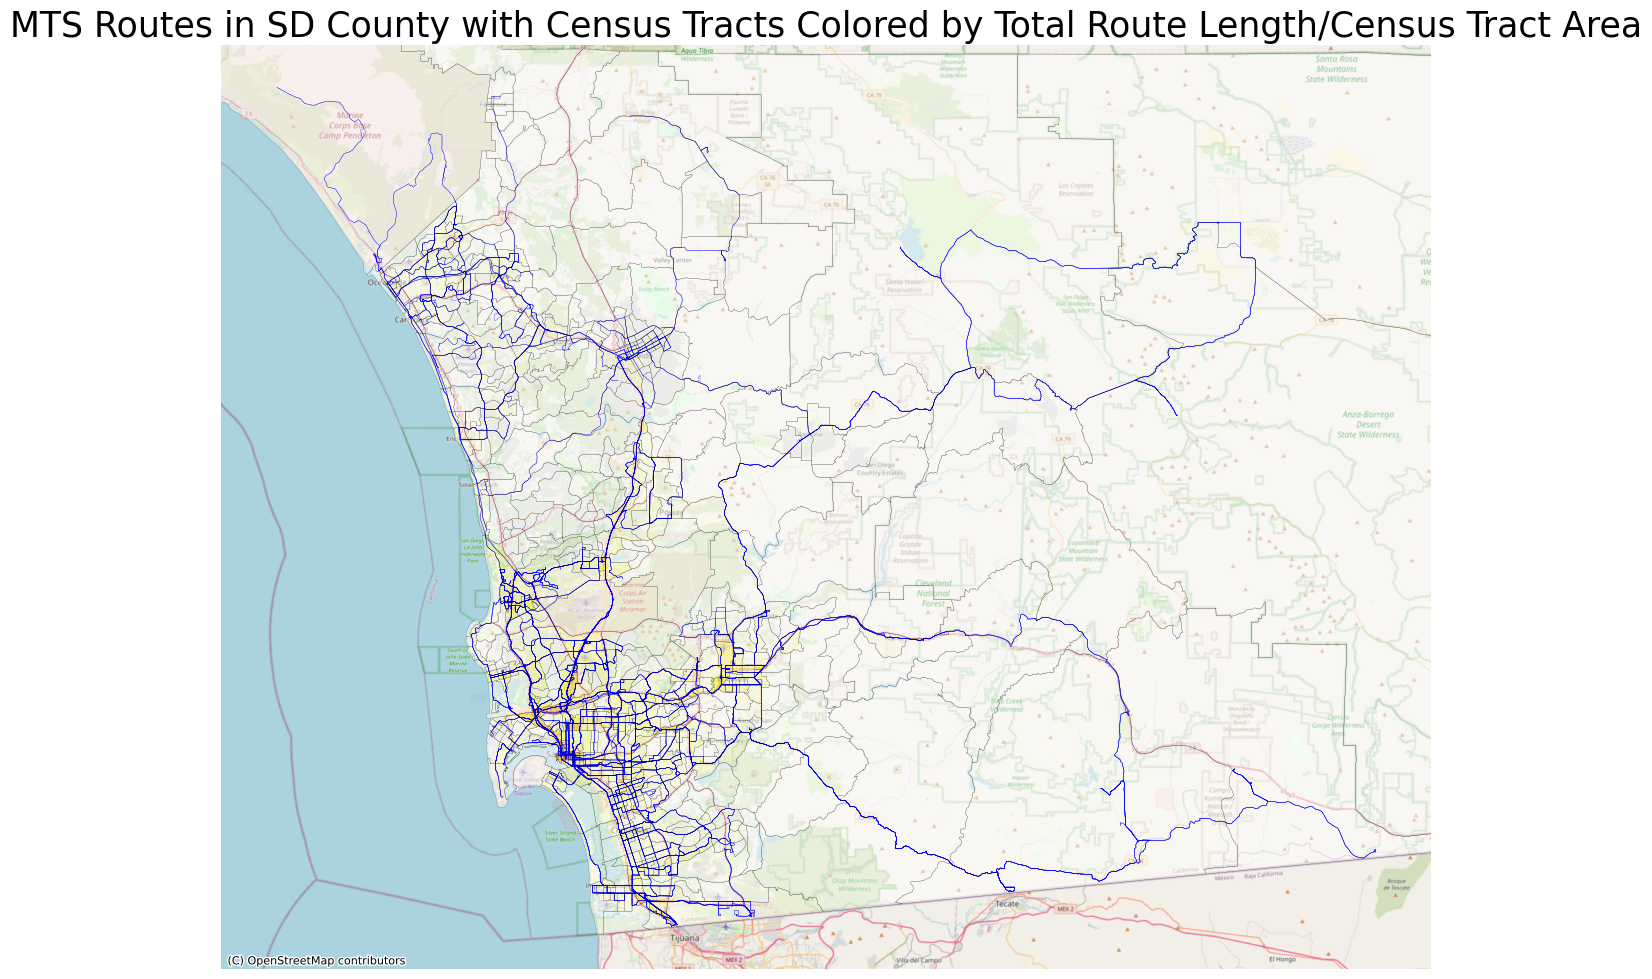

In [182]:
#Testing total route length/census tract area

import contextily as cx

fig, ax = plt.subplots(
    nrows = 1,
    ncols = 1,
    figsize = (16, 12)
)

#Plotting routes
transit_routes_df.plot(ax = ax, linewidth = 0.2, alpha = 1, color = "blue")

#Plotting an OSM basemap
cx.add_basemap(
    ax = ax,
    source = cx.providers.OpenStreetMap.Mapnik,
    zoom = 11,
    crs = transit_routes_df.crs,
)

#Plotting the boundaries of the census tracts
tract_df.boundary.plot(ax = ax, alpha = 1, color = "black", linewidth = 0.1)
tract_df.plot(ax = ax, alpha = 0.5, column = "total_route_length_to_area_ratio", cmap = "hot_r")

ax.axis("off")
plt.title("MTS Routes in SD County with Census Tracts Colored by Total Route Length/Census Tract Area", fontsize = 25)

Text(0.5, 1.0, 'MTS Routes in SD County with Census Tracts Colored by Total Route Length')

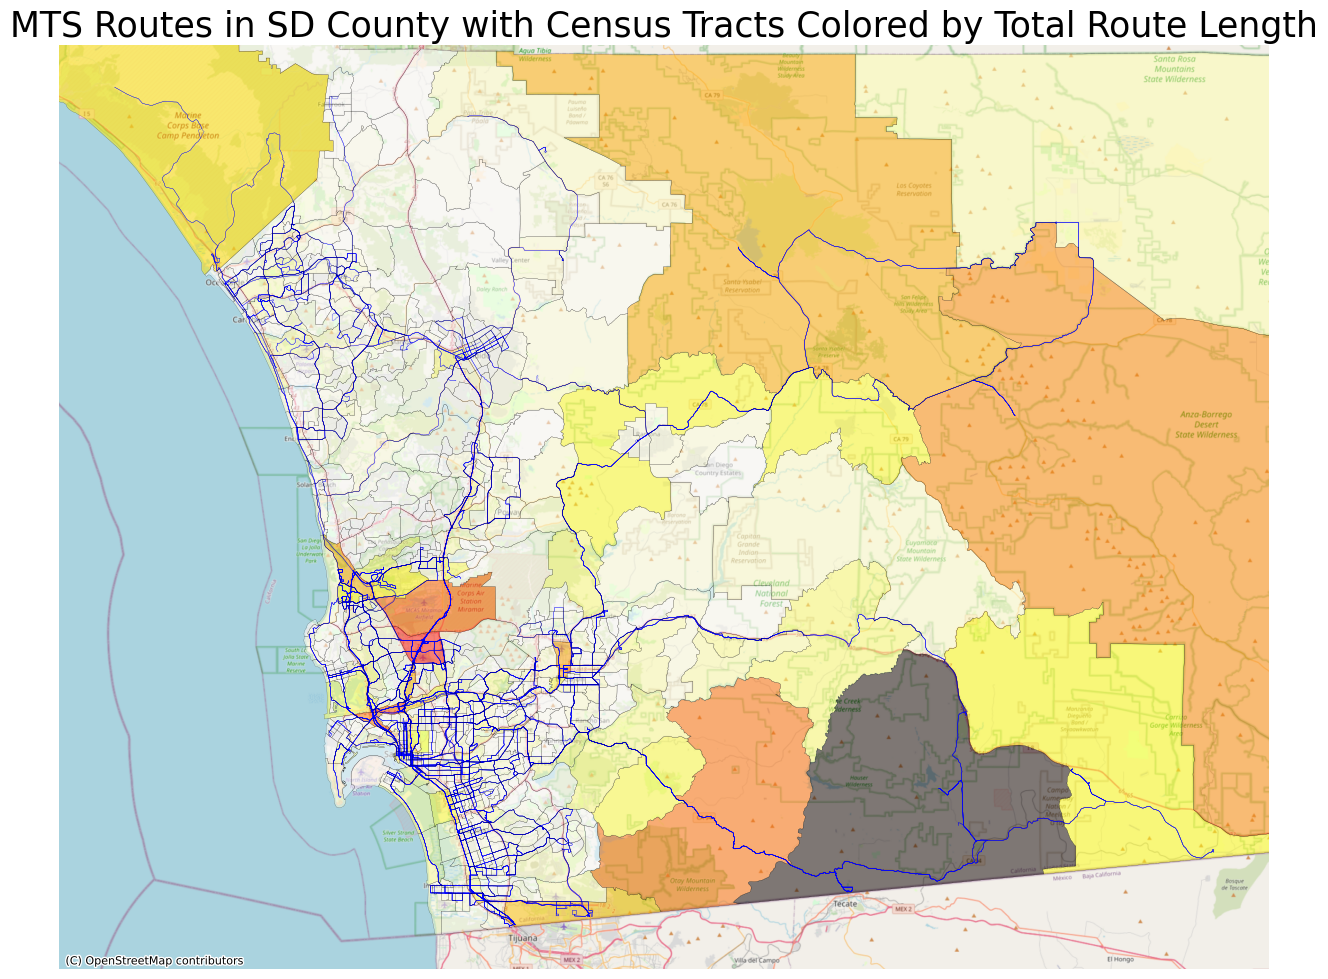

In [183]:
#Testing total route length

import contextily as cx

fig, ax = plt.subplots(
    nrows = 1,
    ncols = 1,
    figsize = (16, 12)
)

#Plotting routes
transit_routes_df.plot(ax = ax, linewidth = 0.2, alpha = 1, color = "blue")

#Plotting an OSM basemap
cx.add_basemap(
    ax = ax,
    source = cx.providers.OpenStreetMap.Mapnik,
    zoom = 11,
    crs = transit_routes_df.crs,
)

#Plotting the boundaries of the census tracts
tract_df.boundary.plot(ax = ax, alpha = 1, color = "black", linewidth = 0.1)
tract_df.plot(ax = ax, alpha = 0.5, column = "total_route_length_m", cmap = "hot_r")

ax.axis("off")
plt.title("MTS Routes in SD County with Census Tracts Colored by Total Route Length", fontsize = 25)